In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-colorblind')
import scipy.stats as sps
import networkx as nx
from Dist_UCB1 import Dist_UCB1
from UCB1 import UCB1
import time
import os
from multiprocess import Pool

n_runs = 100
T = 10000
N = 20
rwd_means = [.2, .3, .4, .5, .6]

seeds = []
myseed = 0
while len(seeds) < n_runs:
    G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=myseed)
    if nx.is_connected(G):
        seeds.append(myseed)
    myseed += 1
sd = 0.1
single_agent_distributions = [sps.beta(rwd_means[i], 1-rwd_means[i]) for i in range(len(rwd_means))]
for i in range(len(rwd_means)):
    single_agent_distributions[i].random_state = np.random.RandomState(seed=1)
distributions = [[sps.beta(rwd_means[i], 1-rwd_means[i]) for i in range(len(rwd_means))] for n in range(N)]
for n in range(N):
    for i in range(len(rwd_means)):
        distributions[n][i].random_state = np.random.RandomState(seed=1)
betas = [1, .1, .01]

In [2]:
def worker(job_runs, seeds, betas, T, N, distributions):
    mean_regrets_dist_ucb1 = np.zeros((len(job_runs), len(betas), T))
    regrets_ucb1 = np.zeros((len(job_runs), T))
    for run in job_runs:
        start_run_t = time.time()
        G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=seeds[run])
        nodes = list(G.nodes)
        for i in nodes:
            G.add_edge(i,i) 
        for b in range(len(betas)):
            distucb1 = Dist_UCB1(T, distributions, G, beta=betas[b])
            distucb1.run()
            mean_regrets_dist_ucb1[run-job_runs[0], b, :] = np.mean(distucb1.regrets, axis=0)
        ucb1 = UCB1(T, single_agent_distributions)
        ucb1.run()
        regrets_ucb1[run-job_runs[0], :] = ucb1.regret
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return mean_regrets_dist_ucb1, regrets_ucb1

In [3]:
mean_regrets_dist_ucb1 = np.zeros((n_runs, len(betas), T))
regrets_ucb1 = np.zeros((n_runs, T))
cpus = os.cpu_count()
init_time = time.time()

pool = Pool()
jobs = list(range(n_runs))
job_size = n_runs // cpus
job_chunks = [(jobs[i:i + job_size], seeds, betas, T, N, distributions) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker, job_chunks)
pool.close()
pool.join()

mean_regrets_dist_ucb1_unconcat = [result[0] for result in results]
regrets_ucb1_unconcat = [result[1] for result in results]
np.concatenate(mean_regrets_dist_ucb1_unconcat, out=mean_regrets_dist_ucb1)
np.concatenate(regrets_ucb1_unconcat, out=regrets_ucb1)
end_run_t = time.time()
time_axis = list(range(T))
mean_regrets_over_all_runs_dist_ucb1 = np.mean(mean_regrets_dist_ucb1, axis=0)
mean_regrets_over_all_runs_ucb1 = np.mean(regrets_ucb1, axis=0)
std_regrets_over_all_runs_dist_ucb1 = np.std(mean_regrets_dist_ucb1, axis=0)
std_regrets_over_all_runs_ucb1 = np.std(regrets_ucb1, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

finished run 24 in 96.79486393928528sec
finished run 0 in 98.1340479850769sec
finished run 36 in 98.3780038356781sec
finished run 72 in 98.36571002006531sec
finished run 60 in 99.59919500350952sec
finished run 12 in 100.29309272766113sec
finished run 48 in 101.71685194969177sec
finished run 1 in 113.83412218093872sec
finished run 73 in 113.84436678886414sec
finished run 37 in 115.08939385414124sec
finished run 25 in 116.95718288421631sec
finished run 13 in 115.31963205337524sec
finished run 61 in 116.77874994277954sec
finished run 49 in 116.6915431022644sec
finished run 2 in 124.17453002929688sec
finished run 26 in 124.48488306999207sec
finished run 74 in 127.91613173484802sec
finished run 38 in 128.83014297485352sec
finished run 62 in 126.49740695953369sec
finished run 14 in 128.00083088874817sec
finished run 50 in 125.49730587005615sec
finished run 3 in 127.72653007507324sec
finished run 27 in 130.35613799095154sec
finished run 15 in 127.06389808654785sec
finished run 51 in 127.57218

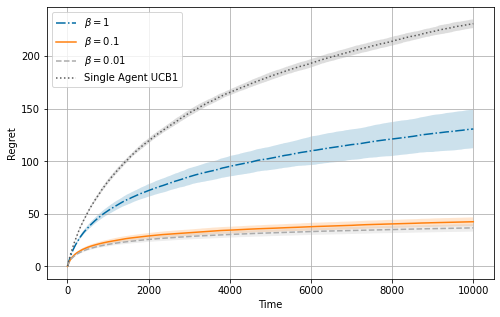

In [4]:
plt.figure(figsize=(8,5))
linestyles = ['-.', '-', '--']
for b in range(len(betas)):
    plt.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[b], linestyles[b], label=r"$\beta=$" + str(betas[b]))
    plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[b]-std_regrets_over_all_runs_dist_ucb1[b], mean_regrets_over_all_runs_dist_ucb1[b]+std_regrets_over_all_runs_dist_ucb1[b],alpha=.2)
plt.plot(time_axis, mean_regrets_over_all_runs_ucb1, ':', label="Single Agent UCB1")
plt.fill_between(time_axis, mean_regrets_over_all_runs_ucb1-std_regrets_over_all_runs_ucb1, mean_regrets_over_all_runs_ucb1+std_regrets_over_all_runs_ucb1, alpha=.2)
plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend()
plt.grid()
plt.savefig("dist_UCB_vs_single_UCB.pdf", bbox_inches='tight')